# Demo: Comparing Optimizers with a Simple MLP

Welcome! This notebook is a warm-up exercise to demonstrate how to compare different training optimizers in PyTorch. We will:
1. Load the classic MNIST dataset of handwritten digits.
2. Build a simple Multi-Layer Perceptron (MLP) model.
3. Train the model using two different optimizers: **SGD** and **Adam**.
4. Compare their performance by plotting validation accuracy.

Follow along with the code to understand the key steps involved.

### 1. Imports and Setup

In [1]:
# Imports and global configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt


# Set a seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(1234)

In [3]:
# Select the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### 2. Data Preparation

In [4]:
# Define the data transforms: convert images to tensors and normalize them
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # MNIST-specific mean and std
    ]
)

In [5]:
# Download and load the MNIST training and test datasets
train_ds_full = datasets.MNIST(
    root="./data", train=True, download=True, transform=data_transforms
)
test_ds = datasets.MNIST(
    root="./data", train=False, download=True, transform=data_transforms
)

# Create a validation split from the training set
val_ratio = 0.1
val_size = int(len(train_ds_full) * val_ratio)
train_size = len(train_ds_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(train_ds_full, [train_size, val_size])

print(
    f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}"
)

# Create DataLoaders to handle batching
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 142kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.15MB/s]


Train size: 54000, Val size: 6000, Test size: 10000


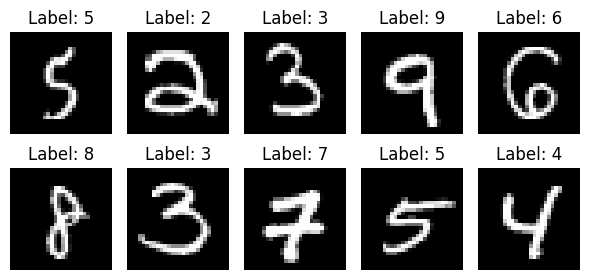

In [6]:
# Helper function to show some sample images
def show_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, ax = plt.subplots(2, 5, figsize=(6, 3))
    for i in range(2):
        for j in range(5):
            idx = i * 5 + j
            ax[i, j].imshow(images[idx].squeeze(), cmap="gray")
            ax[i, j].set_title(f"Label: {labels[idx].item()}")
            ax[i, j].axis("off")
    plt.tight_layout()
    plt.show()


show_images(train_loader)

### 3. Model, Metrics, and Training Utilities

In [7]:
# Define a simple Multi-Layer Perceptron (MLP)
class SimpleMLP(nn.Module):
    def __init__(self, input_size=28 * 28, hidden_size=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten the image from 28x28 to a 784-element vector
        x = torch.flatten(x, 1)
        # Apply ReLU activation after the first layer
        x = F.relu(self.fc1(x))
        # The output of the second layer are the logits
        x = self.fc2(x)
        return x


# You can instantiate the model to check its parameters
model_check = SimpleMLP()
print(f"Total parameters: {sum(p.numel() for p in model_check.parameters())}")

Total parameters: 101770


In [8]:
# Function to compute accuracy from model outputs (logits)
@torch.no_grad()
def accuracy_from_logits(logits, y):
    # Get predicted class by finding the index with the highest logit value
    preds = logits.argmax(dim=1)
    # Check if predictions match the true labels
    correct = preds == y
    # Return the mean accuracy for the batch
    return correct.float().mean().item()

In [9]:
# Function for a single training epoch
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss, running_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()
        # 2. Get model predictions (forward pass)
        logits = model(x)
        # 3. Calculate the loss
        loss = criterion(logits, y)
        # 4. Compute gradients (backward pass)
        loss.backward()
        # 5. Update model weights
        optimizer.step()

        # Update stats
        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy_from_logits(logits, y) * batch_size
        n += batch_size

    return running_loss / n, running_acc / n

In [10]:
# Function to evaluate the model on validation or test data
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        # Update stats
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_acc += accuracy_from_logits(logits, y) * batch_size
        n += batch_size

    return total_loss / n, total_acc / n

### 4. Optimizer Bake-Off

In [11]:
# Loss function for classification
criterion = nn.CrossEntropyLoss()


# Function to create a new model instance for each experiment
def make_fresh_model():
    return SimpleMLP().to(device)


# Define the optimizer configurations we want to compare
optim_configs = {"sgd": {"lr": 1e-2, "momentum": 0.9}, "adam": {"lr": 1e-3}}


# Helper function to create an optimizer for a given model
def make_optimizer(name, params):
    if name == "sgd":
        return optim.SGD(params, **optim_configs["sgd"])
    if name == "adam":
        return optim.Adam(params, **optim_configs["adam"])
    raise ValueError("Unknown optimizer")

In [12]:
# Main training loop to compare optimizers
EPOCHS = 3
histories = {}

for opt_name in ["sgd", "adam"]:
    print(f"\n=== Training with {opt_name.upper()} ===")
    set_seed(1234)  # Reset seed for a fair comparison
    model = make_fresh_model()
    optimizer = make_optimizer(opt_name, model.parameters())

    # Store metrics for this run
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, EPOCHS + 1):
        # Train for one epoch
        tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, device)
        # Evaluate on the validation set
        vl, va = evaluate(model, val_loader, criterion, device)

        # Save metrics
        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["val_loss"].append(vl)
        history["val_acc"].append(va)

        print(
            f"Epoch {epoch:02d} | train loss {tl:.4f} acc {ta:.4f} | val loss {vl:.4f} acc {va:.4f}"
        )

    histories[opt_name] = history

print("\nDone training all optimizers.")


=== Training with SGD ===
Epoch 01 | train loss 0.2941 acc 0.9137 | val loss 0.1683 acc 0.9497
Epoch 02 | train loss 0.1245 acc 0.9627 | val loss 0.1249 acc 0.9652
Epoch 03 | train loss 0.0869 acc 0.9746 | val loss 0.1028 acc 0.9683

=== Training with ADAM ===
Epoch 01 | train loss 0.2705 acc 0.9211 | val loss 0.1621 acc 0.9513
Epoch 02 | train loss 0.1202 acc 0.9637 | val loss 0.1282 acc 0.9613
Epoch 03 | train loss 0.0826 acc 0.9754 | val loss 0.1059 acc 0.9688

Done training all optimizers.


### 5. Results and Final Evaluation

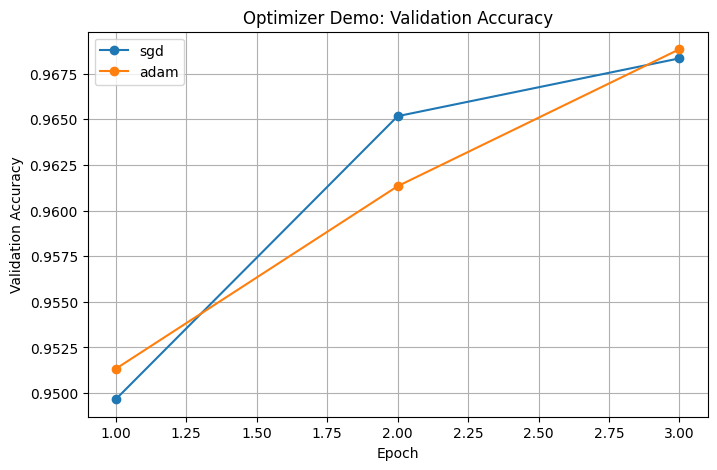

In [13]:
# Plot validation accuracy curves to compare performance
plt.figure(figsize=(8, 5))
for name, h in histories.items():
    plt.plot(range(1, EPOCHS + 1), h["val_acc"], label=name, marker="o")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Optimizer Demo: Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Find the best optimizer based on the highest validation accuracy
best_name = max(histories.keys(), key=lambda n: max(histories[n]["val_acc"]))
print(f"Best optimizer by validation accuracy: {best_name.upper()}")

# Retrain the model with the best optimizer and evaluate on the test set
print("\nTraining final model...")
set_seed(1234)
best_model = make_fresh_model()
best_opt = make_optimizer(best_name, best_model.parameters())

for epoch in range(EPOCHS):
    train_one_epoch(best_model, train_loader, criterion, best_opt, device)

# Final evaluation on the unseen test set
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy with {best_name.upper()}: {test_acc:.4f}")

Best optimizer by validation accuracy: ADAM

Training final model...

Final Test Accuracy with ADAM: 0.9708


<br /><br /><br /><br /><br /><br /><br /><br /><br />